In [46]:
import rasterio
import numpy as np
import os
from SatCam import SatCam, SatellitePose
import pyproj
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import csv

In [3]:
# Example satellite pose
pose = [549496.7936069818, -6128343.990241624, 3287548.8567509046, -0.07876803246160267, 0.878472092968163, -0.4712561712468741, -0.04208625123151773, 0.46937312065726633, 0.8819963838144332, 0.9960041890069568, 0.08930652540881052, -0.0]
pose = SatellitePose(pose)

# Instantiate SatCam with referene camera parameters
satcam = SatCam(pose, hfov = 66, w_px = 4608, h_px = 2592)

In [4]:
# Define region for image
region = '17R'

In [6]:
# Get image path
base_path = 'region_ims'
crs = 'EPSG:3857'
region_path = os.path.join(base_path, region)
if os.path.exists(region_path):
    random_regim = np.random.choice(os.listdir(region_path))
    regim_path = os.path.join(region_path, random_regim)

In [11]:
# get lonlats of corner pixels
corner_lonlats = satcam.get_corner_lonlats()
print(corner_lonlats)

tl_lon, tl_lat = corner_lonlats['tl']
br_lon, br_lat = corner_lonlats['br']
bl_lon, bl_lat = corner_lonlats['bl']
tr_lon, tr_lat = corner_lonlats['tr']

{'tl': (-89.06500134909436, 30.257888000513418), 'tr': (-80.68757210719025, 30.257888000513418), 'br': (-80.85294601399994, 26.17564331771982), 'bl': (-88.89962744228467, 26.175643317719818)}


In [10]:
# Get minimum and maximum lonlats
min_lon = min(tl_lon, bl_lon)
max_lon = max(tr_lon, br_lon)
min_lat = min(bl_lat, br_lat)
max_lat = max(tl_lat, tr_lat)
print(min_lon, max_lon, min_lat, max_lat)

-89.06500134909436 -80.68757210719025 26.175643317719818 30.257888000513418


In [13]:
# make projector from epsg:4326 to epsg:3857
p = pyproj.Proj('EPSG:3857')

In [16]:
# Convert lonlats to xys
min_x, min_y = p(min_lon, min_lat)
max_x, max_y = p(max_lon, max_lat)
print(min_x, max_x, min_y, max_y)

-9914670.597683407 -8982099.440317962 3020851.4338512695 3536742.1999271573


In [20]:
# Open raster image
src = rasterio.open(regim_path)

In [21]:
# get image window and window transform
window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
window_transform = rasterio.windows.transform(window, src.transform)

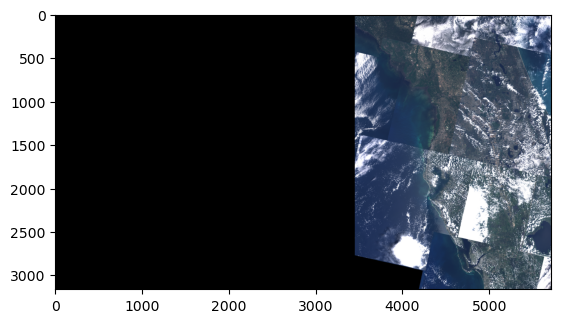

In [29]:
# get windowed image
windowed_im = src.read(window=window, boundless=True)
windowed_im = np.moveaxis(windowed_im, 0, -1)
plt.imshow(windowed_im)

In [30]:
# import YOLO
from ultralytics import YOLO 

#define model path
model_path = 'models/' + region + '.pt'

#load model
model = YOLO(model_path)



In [33]:
# get best classes for region and confidence threshold for region
conf_threshold = float(np.load('best_confs/' + region + '_best_conf.npy'))
best_classes = np.load('best_classes/' + region + '_best_classes.npy')

# predict on image
results = model(windowed_im, classes=best_classes, conf=conf_threshold, imgsz=(2592, 4608))

0: 2560x4608 1 46, 2 49s, 1 215, 1 266, 1 387, 1 389, 232.5ms
Speed: 137.0ms preprocess, 232.5ms inference, 4.5ms postprocess per image at shape (1, 3, 2560, 4608)


In [43]:
def convert_xc_yc_to_lon_lat(xc, yc, window_transform):
    # convert to pixel coordinates
    x, y = window_transform * (xc, yc)
    # convert to lonlat
    lon, lat = p(x, y, inverse=True)
    return lon, lat

In [47]:
def convert_cls_to_lon_lat(cls, region):
    path = 'landmark_csvs/' + region + '_top_salient.csv'
    with open(path, 'r') as f:
        reader = csv.DictReader(f)
        dict_list = list(reader)
    cls_dict = dict_list[cls]
    lon = cls_dict['Centroid Longitude']
    lat = cls_dict['Centroid Latitude']
    return lon, lat


In [48]:
result = results[0]
for detection in result.boxes:
    cls = int(detection.cls.item())
    xc, yc, w, h = detection.xywh[0]
    xc, yc, w, h = xc.item(), yc.item(), w.item(), h.item()
    det_lon, det_lat = convert_xc_yc_to_lon_lat(xc, yc, window_transform)
    cls_lon, cls_lat = convert_cls_to_lon_lat(cls, region)
    print(det_lon, det_lat, cls_lon, cls_lat)

-82.12488013927012 26.809260191993303 -82.13333333333333  26.816666666666666
-82.11122868911292 26.827455965196048 -82.10833333333333  26.825
-82.11806765829597 26.744981093003453 -82.125  26.741666666666667
-81.60459730795027 29.281689964226008 -81.6  29.28333333333333
-82.1062310083983 26.81838559685367 -82.10833333333333  26.825
-82.12727839602331 26.901203224437054 -82.125  26.90833333333333
-81.59432775776385 29.26827840429568 -81.59166666666667  29.275


In [42]:
window_transform * (xc.item(), yc.item())

(-9083039.017613739, 3409836.3785138135)